# Preprocessing


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Functions_examples import *

## Load data 

In [2]:
data = load_pickle_variable('../Data/Dataset_4subjects_Exe_Obs')

## Subsample the data 

Sampling frequency :

Subsampling : 500 Hz (suggested)

_make sure to respect the Nyquist theorem_

In [3]:
datac = data.copy()
subsample_rate = 2048 // 500

for subject, sub_data in datac.items():
    for session, sess_data in sub_data.items():
        nb_channels = len(sess_data['channel_labels'])
        sess_data['sub_neural_data'] = {}
        for channel in range(nb_channels):
            sess_data['sub_neural_data'][channel] = sess_data['neural_data'][channel][::subsample_rate]

## Problems due to bipolar referencing

For every electrode shaft, if a signal looks weird (=flat), it is likely that the signal is bipolar-referenced. The signal needs to be removed

## Filtering 

sEEG data : up to 150 Hz

Divide the signals in the usual different frequency bands :
- Delta (0.5-4 Hz)
- Theta (4-8 Hz)
- Alpha (8-13 Hz)
- Beta (13-30 Hz)
- Gamma (30-100 Hz)

Maybe try other separations of frequency bands (e.g. low and high gamma, low and high beta, etc.)

In [4]:
from scipy.signal import butter, sosfilt

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a bandpass filter to the input data.

    Parameters:
    - data: 1D NumPy array, the signal to filter.
    - lowcut: float, lower frequency of the band (Hz).
    - highcut: float, upper frequency of the band (Hz).
    - fs: float, sampling frequency of the signal (Hz).
    - order: int, the order of the filter.

    Returns:
    - filtered_data: 1D NumPy array, the filtered signal.
    """
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, data)

freq_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 100)
}

sub_data = datac['s6']['sess1']['sub_neural_data']
filtered_data = {}
for band_name, (low, high) in freq_bands.items():
    filtered_data[band_name] = []
    for channel in range(len(sub_data)):
        filtered_channel = bandpass_filter(sub_data[channel], low, high, 500)
        filtered_data[band_name].append(filtered_channel)
    print(band_name)

Delta
Theta
Alpha
Beta
Gamma


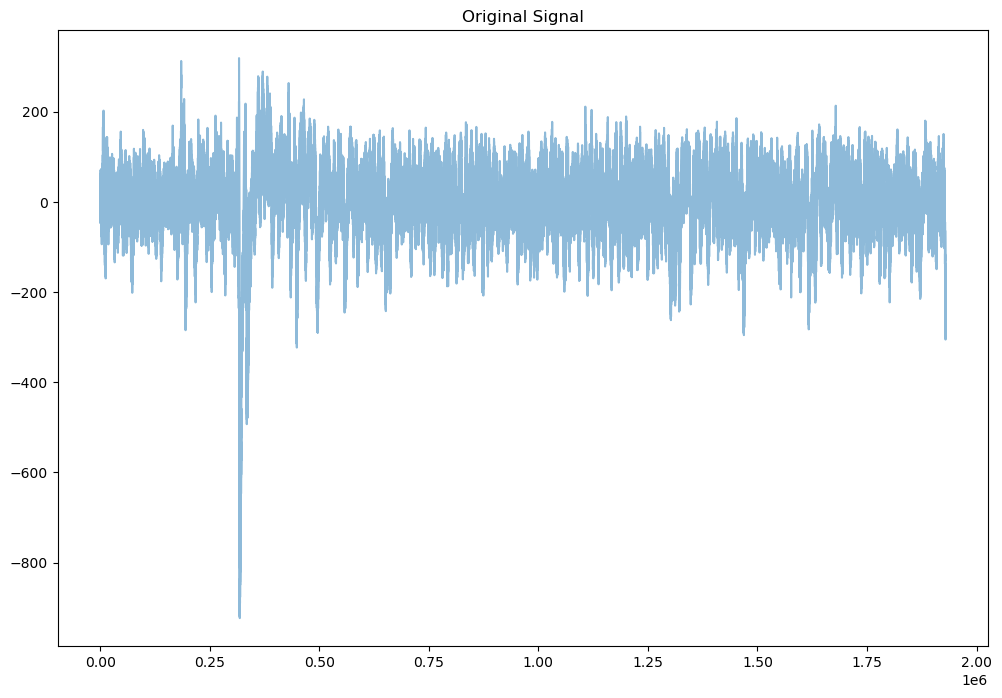

c:\Users\samue\anaconda3\envs\mlcourse\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


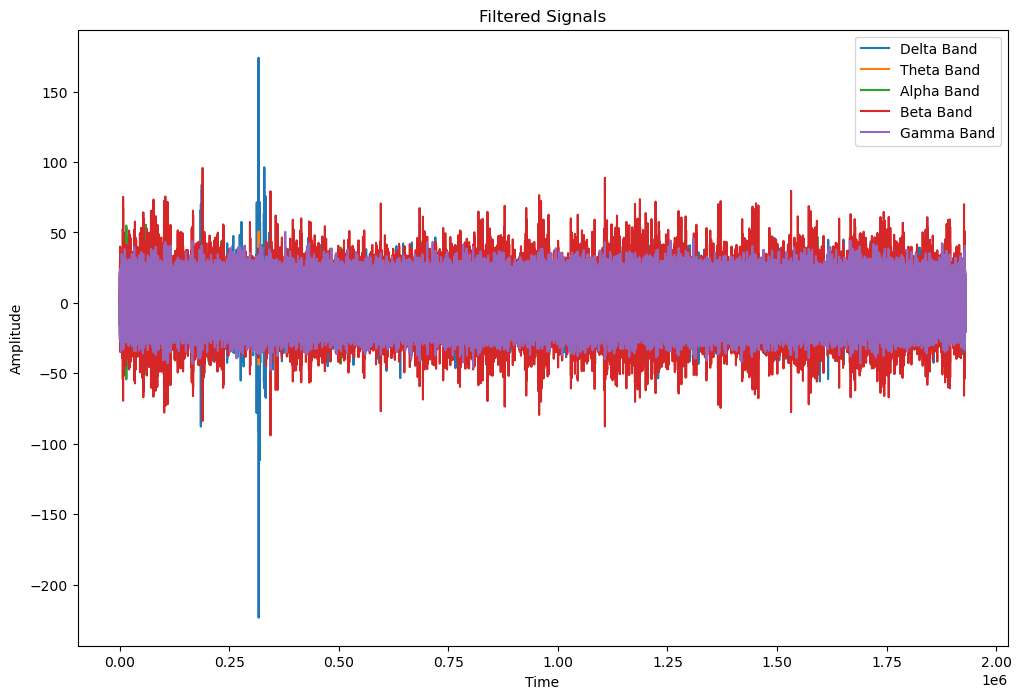

In [5]:
channel_idx = 0

time = np.arange(len(sub_data[channel_idx]))
plt.figure(figsize=(12, 8))
plt.plot(time, sub_data[channel_idx], label="Original Signal", alpha=0.5)
plt.title("Original Signal")
plt.show()

plt.figure(figsize=(12, 8))

for band_name, signals in filtered_data.items():
    plt.plot(time, signals[channel_idx], label=f"{band_name} Band")

plt.title("Filtered Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## Normalization

Methods 
- Normalize the data related to the trial itself by its respective baseline 
    -  1 second before TrialStart and CueOne
- Normalize the data related to the average baseline
    - Average of the segment from TrialStart to CueOne from all trials 

In [254]:
participant = 's6'
session = 'sess1'
has_no_error = np.array(data[participant][session]['trials_info']['ErrorType']) == 'NoError'

start_frames = np.array(data[participant][session]['trials_info']['TS_TrialStart'])[has_no_error] * 500
CueOn_frames = np.array(data[participant][session]['trials_info']['TS_CueOn'])[has_no_error] * 500
CueOff_frames = np.array(data[participant][session]['trials_info']['TS_CueOff'])[has_no_error] * 500
GoSignal_frames = np.array(data[participant][session]['trials_info']['TS_GoSignal'])[has_no_error] * 500
HandOut_frames = np.array(data[participant][session]['trials_info']['TS_HandOut'])[has_no_error] * 500
ObjectGrasp_frames = np.array(data[participant][session]['trials_info']['TS_ObjectGrasp'])[has_no_error] * 500
ObjectReplace_frames = np.array(data[participant][session]['trials_info']['TS_ObjectReplace'])[has_no_error] * 500
HandBack_frames = np.array(data[participant][session]['trials_info']['TS_HandBack'])[has_no_error] * 500

In [ ]:
def normalize_signal_individual_trial(signal, start_frames, CueOn_frames, end_frames, how='standardize'):
    '''
    Normalize the signal with the baseline period for each trial.
    
    Parameters:
    - signal: 1D NumPy array, the signal to normalize.
    - start_frames: 1D NumPy array, the start frames of the trials.
    - CueOn_frames: 1D NumPy array, the CueOn frames of the trials.
    - end_frames: 1D NumPy array, the end frames of the trials (Hand Back).
    - how: string, the normalization method to use. Either 'standardize' or 'divide_by_mean'.
    
    Returns:
    - normalized_signal: 1D NumPy array, the normalized signal.
    '''
    
    normalized_signal = signal.copy()
    for i in range(len(start_frames)):
        start = np.round(start_frames[i]).astype(int)
        end_baseline = np.round(CueOn_frames[i]).astype(int)
        end = np.round(end_frames[i]).astype(int)
        mean = signal[start:end_baseline].mean()
        std = signal[start:end_baseline].std()
        if how == 'standardize':
            normalized_signal[end_baseline:end] -= mean
            normalized_signal[end_baseline:end] /= std
        elif how == 'divide_by_mean':
            normalized_signal[end_baseline:end] /= mean
    return normalized_signal

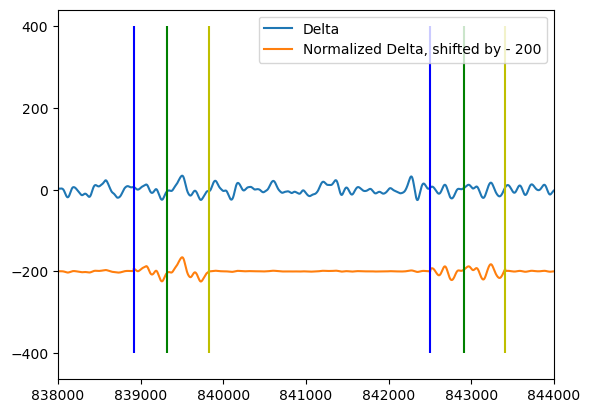

In [236]:
plt.plot(filtered_data['Delta'][0])
plt.plot(normalize_signal_individual_trial(filtered_data['Delta'][0], start_frames, CueOn_frames, HandBack_frames)-200)
plt.vlines(start_frames, -400,400, colors='g')
plt.vlines(CueOn_frames, -400,400, colors='y')
plt.vlines(HandBack_frames, -400,400, colors='b')
plt.xlim(838000, 844000)
plt.legend(['Delta', 'Normalized Delta, shifted by - 200'])
plt.show()

In [238]:
def normalize_signal_over_all_trials (signal, start_frames, CueOn_frames, how='standardize'):
    '''
    Normalize the entire signal with the average of the baseline periods over all trials.
    
    Parameters:
    - signal: 1D NumPy array, the signal to normalize.
    - start_frames: 1D NumPy array, the start frames of the trials.
    - CueOn_frames: 1D NumPy array, the CueOn frames of the trials.
    - how: string, the normalization method to use. Either 'standardize' or 'divide_by_mean'.
    
    Returns:
    - normalized_signal: 1D NumPy array, the normalized signal.
    '''
    
    normalized_signal = signal.copy()
    baseline = []
    for i in range(len(start_frames)):
        start = np.round(start_frames[i]).astype(int)
        end_baseline = np.round(CueOn_frames[i]).astype(int)
        baseline.append(signal[start:end_baseline])
    baseline = np.concatenate(baseline)
    mean = baseline.mean()
    std = baseline.std()
    if how == 'standardize':
        normalized_signal -= mean
        normalized_signal /= std
    elif how == 'divide_by_mean':
        normalized_signal /= mean
    return normalized_signal

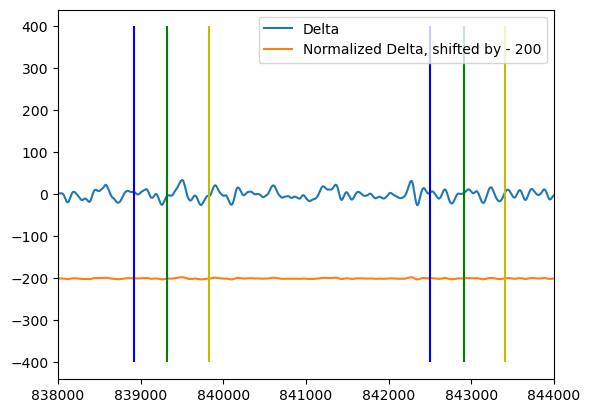

In [239]:
plt.plot(filtered_data['Delta'][0])
plt.plot(normalize_signal_over_all_trials(filtered_data['Delta'][0], start_frames, CueOn_frames)-200)
plt.vlines(start_frames, -400,400, colors='g')
plt.vlines(CueOn_frames, -400,400, colors='y')
plt.vlines(HandBack_frames, -400,400, colors='b')
plt.xlim(838000, 844000)
plt.legend(['Delta', 'Normalized Delta, shifted by - 200'])
plt.show()

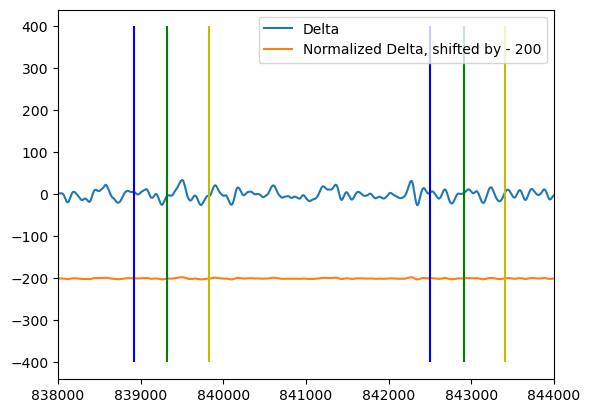

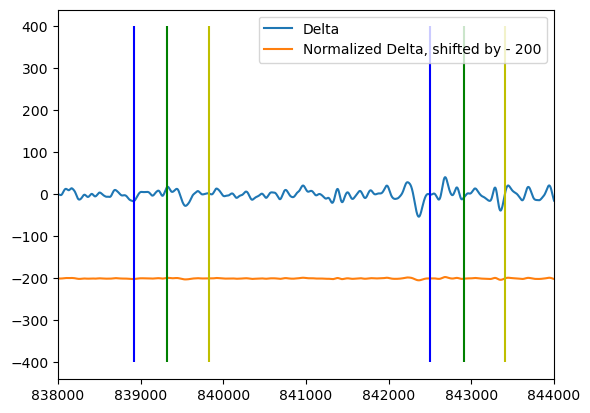

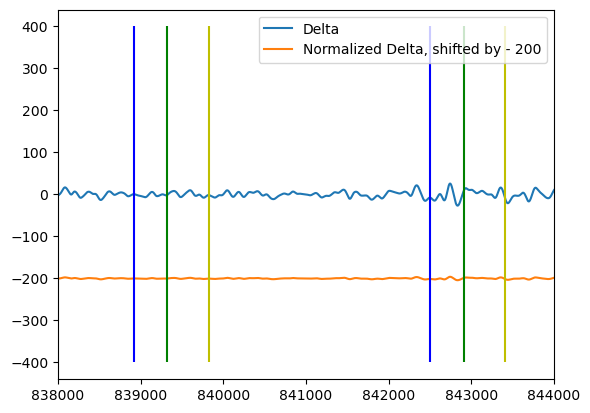

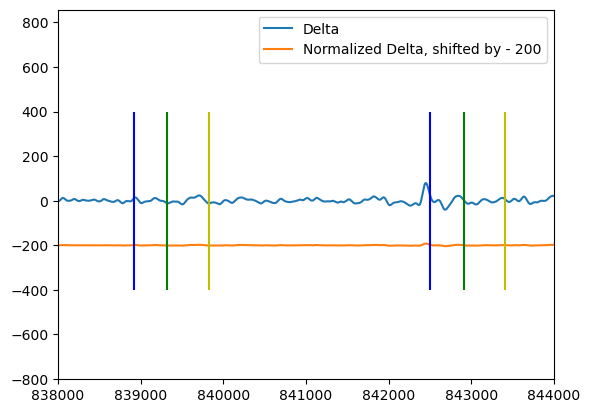

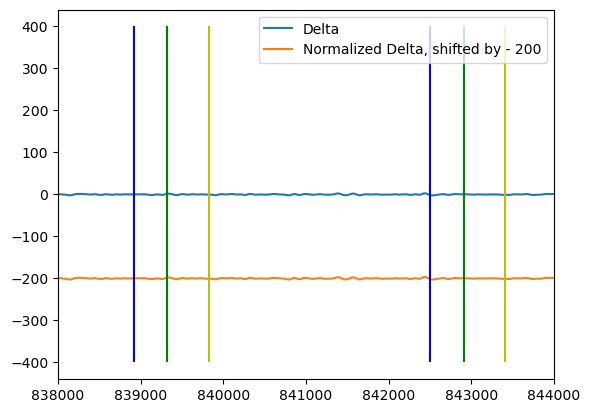

In [240]:
for i in [0,1,2,3,4]:
    plt.plot(filtered_data['Delta'][i])
    plt.plot(normalize_signal_over_all_trials(filtered_data['Delta'][i], start_frames, CueOn_frames)-200)
    plt.vlines(start_frames, -400,400, colors='g')
    plt.vlines(CueOn_frames, -400,400, colors='y')
    plt.vlines(HandBack_frames, -400,400, colors='b')
    plt.xlim(838000, 844000)
    plt.legend(['Delta', 'Normalized Delta, shifted by - 200'])
    plt.show()

## Trial duration

Every trial have a different duration 

Methods 
- Cut segments of neural data around a certain trigger of interest 
- Normalizing the duration of the trials loosing the absolute temporal information
    - Every trial corresponds to 100% of the movement
    - Subsample or upsample every trial to have the same number of points 

In [6]:
subject = 's6'
session = 'sess1'
channel_idx = 0
has_no_error = np.array(data[subject][session]['trials_info']['ErrorType']) == 'NoError'

signal = data[subject][session]['neural_data'][channel_idx]

trial_starts = np.array(data[subject][session]['trials_info']['TS_TrialStart'])[has_no_error]

Dur_trial = np.array(data[subject][session]['trials_info']['Dur_GoBack']) + np.array(data[subject][session]['trials_info']['Dur_Grasped']) + np.array(data[subject][session]['trials_info']['Dur_Reaching']) + np.array(data[subject][session]['trials_info']['Dur_ReacTime']) + np.array(data[subject][session]['trials_info']['Dur_WaitToGo']) + np.array(data[subject][session]['trials_info']['Dur_Cue']) + np.array(data[subject][session]['trials_info']['Dur_Baseline'])
Dur_trial = Dur_trial [has_no_error] // (1000 / 2048)

trials = []
end_frames = trial_starts + Dur_trial
for i in range(len(trial_starts)):
    trial_frames = signal[np.round(trial_starts[i]).astype(int):np.round(end_frames[i]).astype(int)]
    trials.append(trial_frames)

downsampled_trials = []
for trial in trials:
    downsampled_trial = trial[::len(trial)//3200]
    downsampled_trials.append(downsampled_trial)

for i in [0,1,2,3,4,5,6,7,8,9,10]:
    print(len(downsampled_trials[i]))

3585
3799
3474
3247
3450
3619
3263
4240
4259
3329
3286
